In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression  
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score,recall_score
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, GridSearchCV

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

%config InlineBackend.figure_format = 'retina'
# to display all columns and rows:
pd.set_option('display.max_columns', None); pd.set_option('display.max_rows', None);

In [48]:
df = pd.read_csv("~/Desktop/churn.csv", index_col=0)

In [49]:
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [50]:
df['NumOfProducts'].unique()

array([1, 3, 2, 4], dtype=int64)

In [51]:
df.isnull().sum()

CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [52]:
def remove_outliers(df,variable):
    IQR = df[variable].quantile(0.90) - df[variable].quantile(0.10)
    
    lower_range = df[variable].quantile(0.10) - (1.5 * IQR)
    upper_range = df[variable].quantile(0.90) + (1.5 * IQR)
    
    df.loc[df[variable] <= lower_range, variable] = lower_range
    df.loc[df[variable] >= upper_range, variable] = upper_range

<Axes: xlabel='Age'>

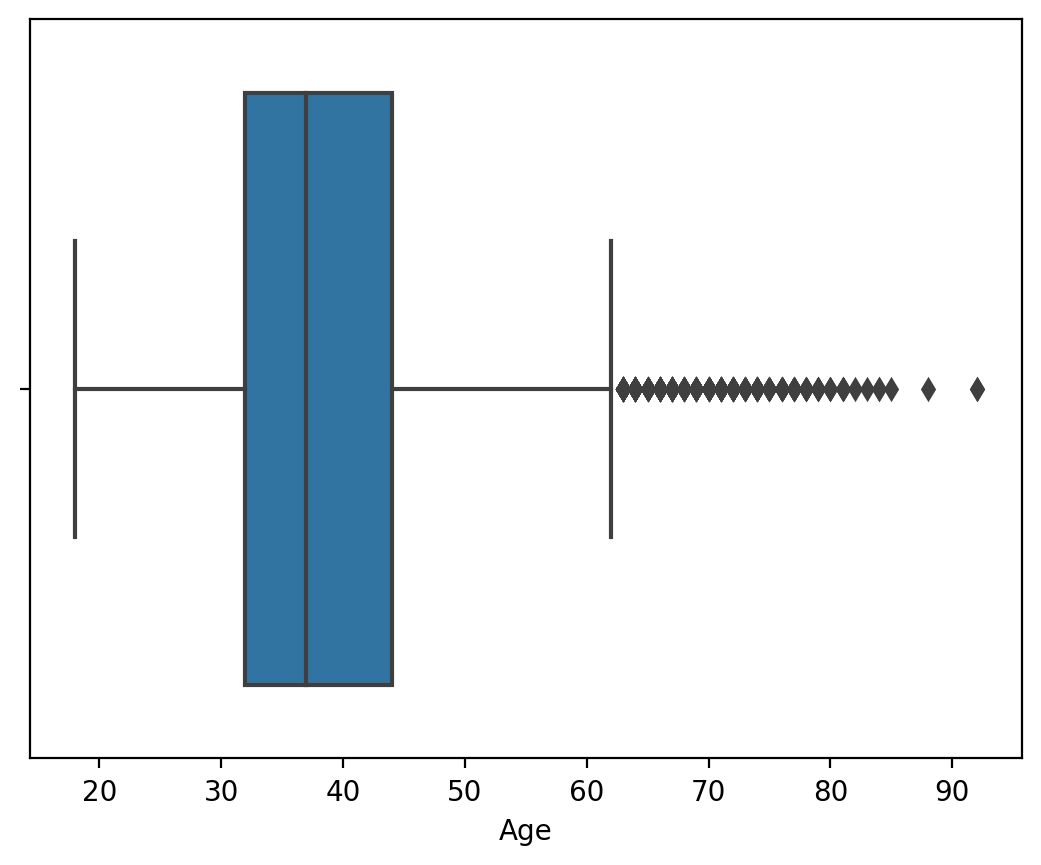

In [53]:
sns.boxplot(x=df['Age'])

In [54]:
remove_outliers(df,'Age')

<Axes: xlabel='Age'>

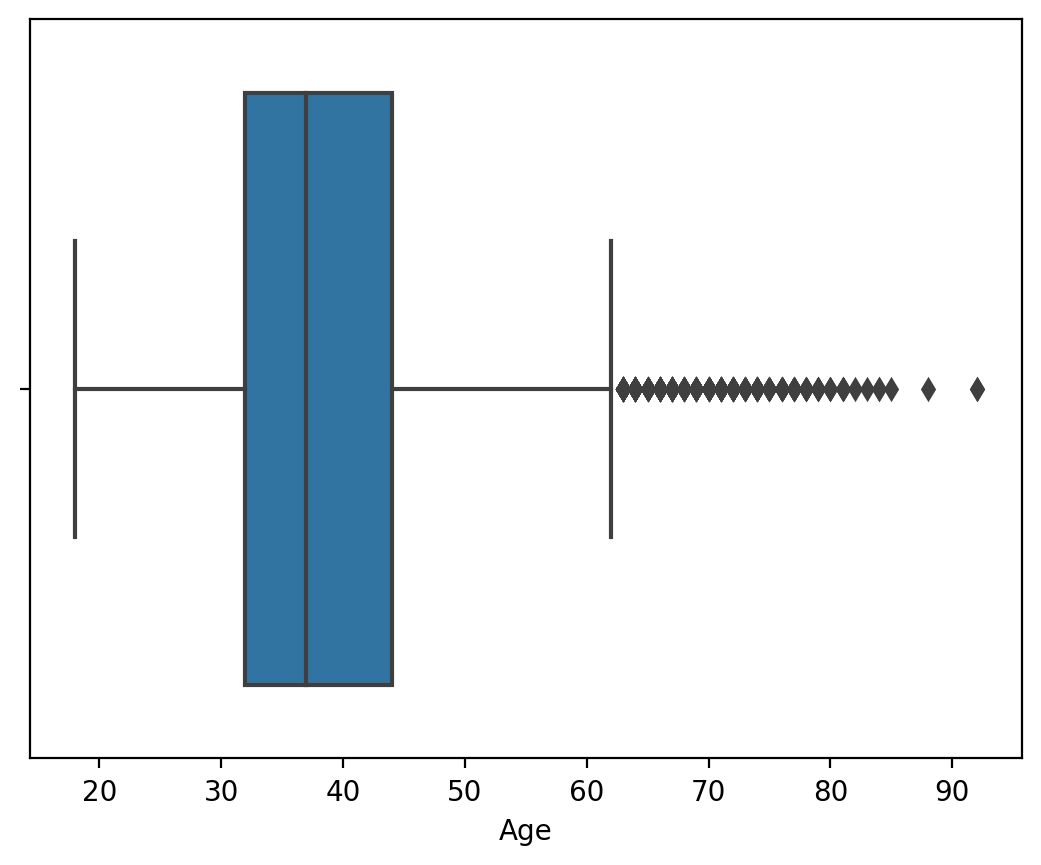

In [55]:
sns.boxplot(x=df['Age'])

<Axes: >

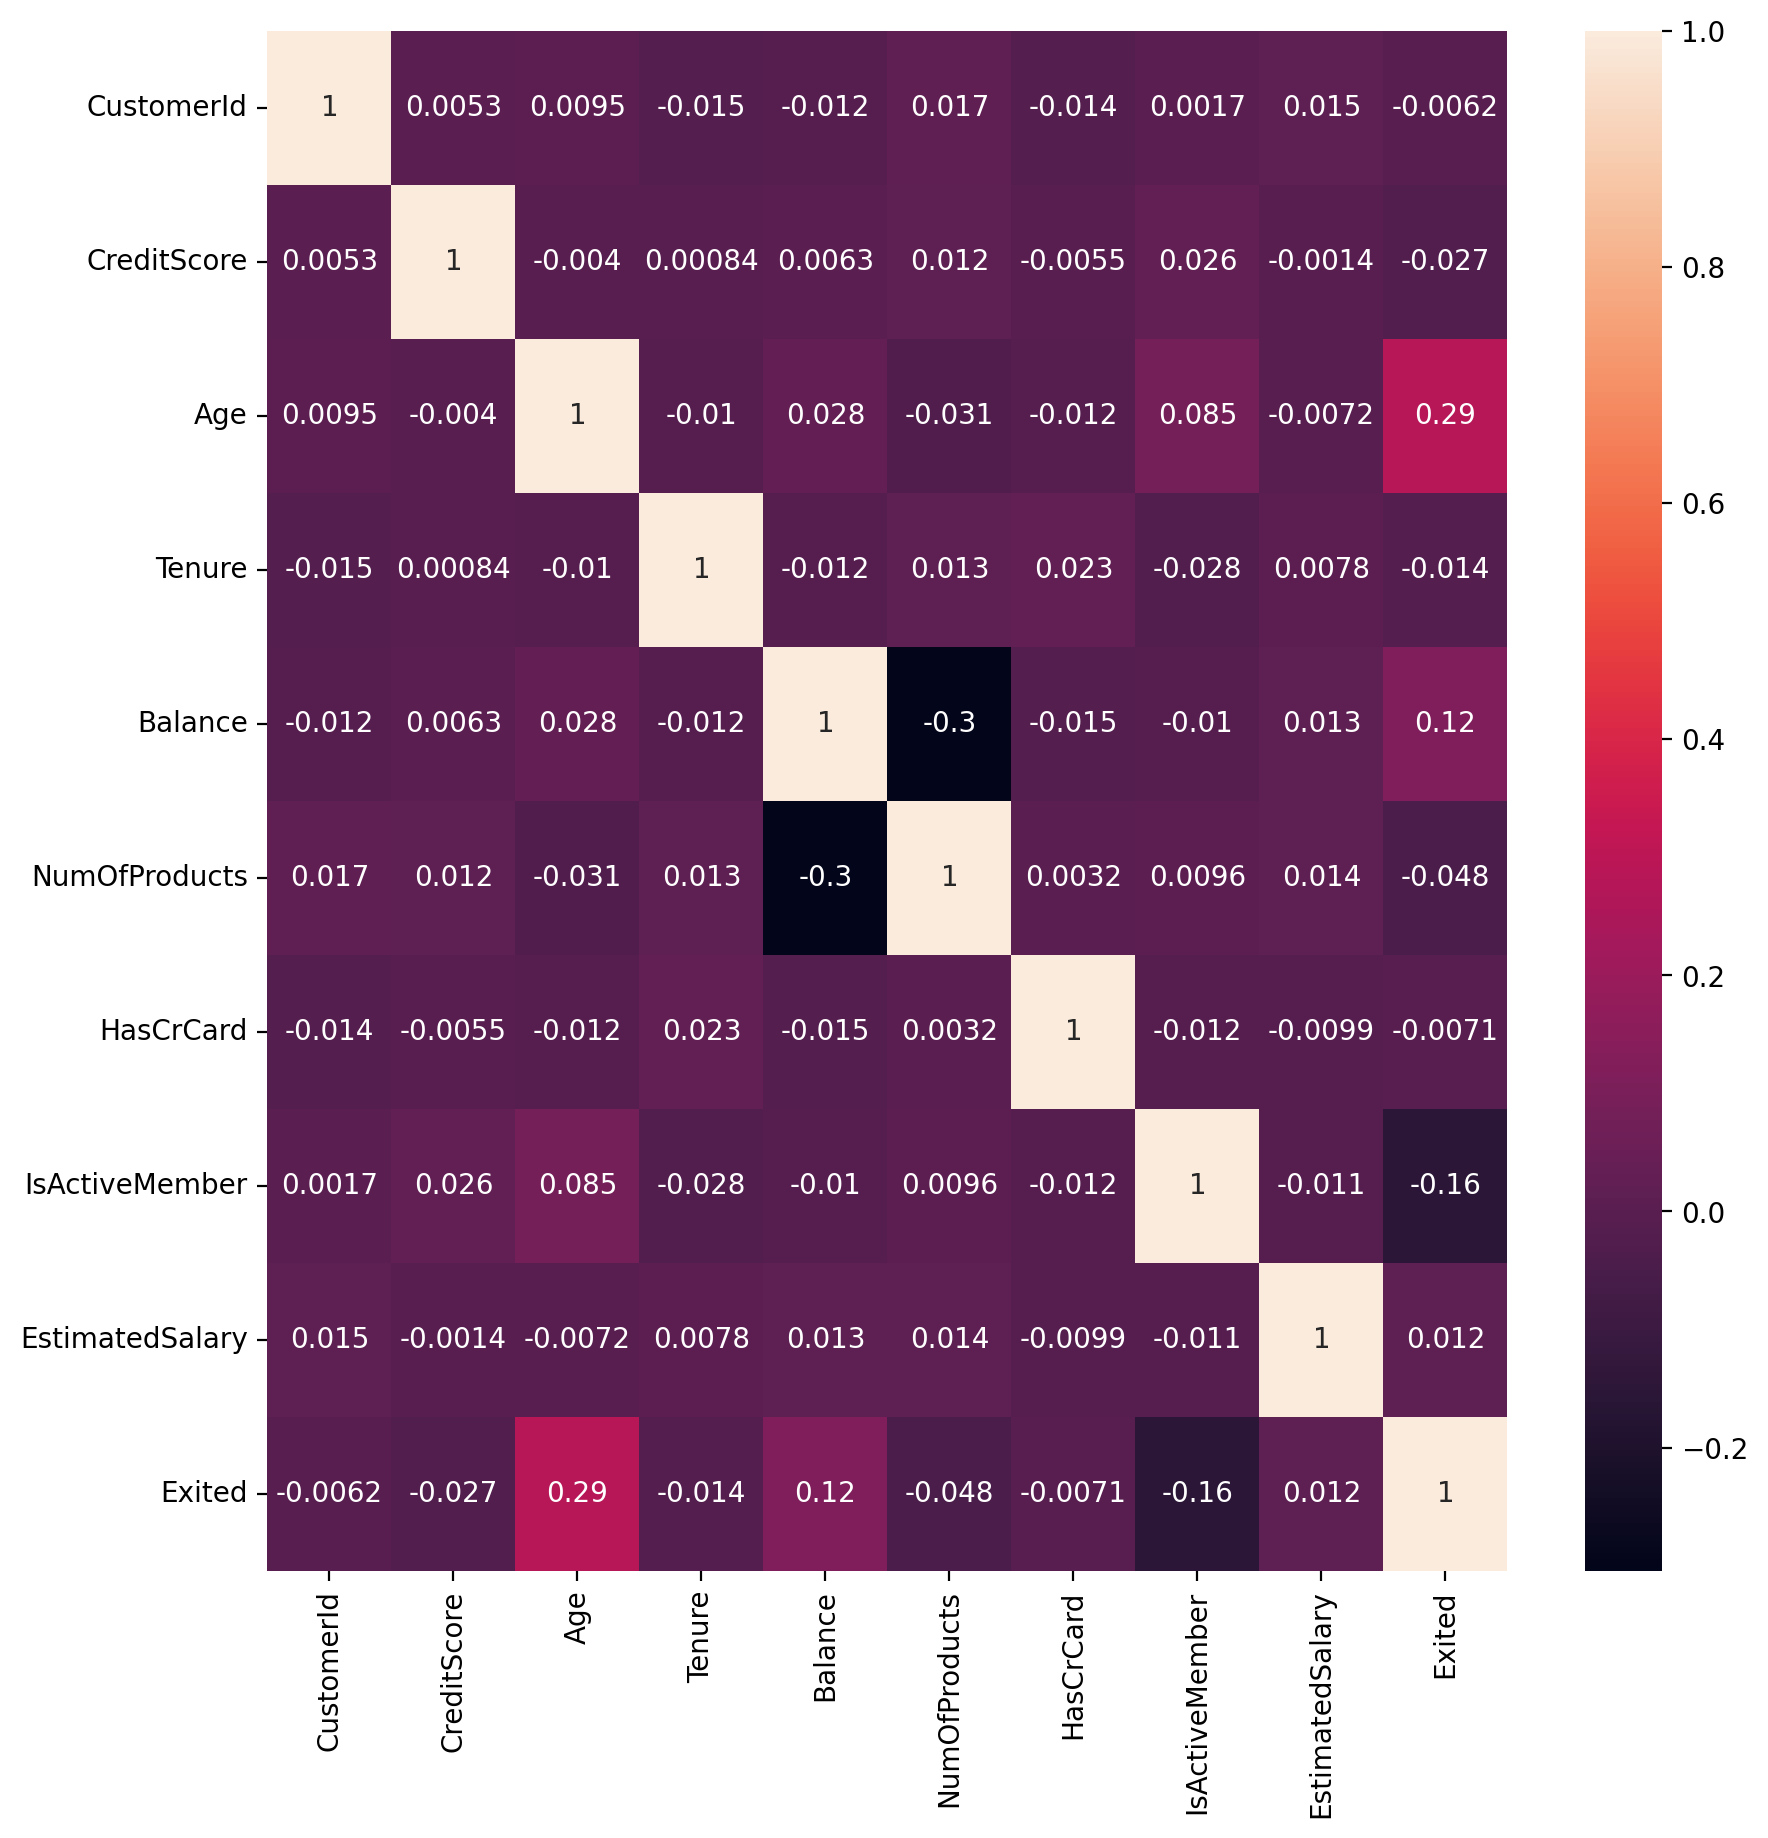

In [56]:
numeric_df = df.select_dtypes(include=['number'])
plt.figure(figsize=(10, 10))
corr = numeric_df.corr()
sns.heatmap(corr, annot=True)

In [57]:
df = df.drop(['CustomerId','Surname'], axis=1)

In [58]:
categorical_variables = [col for col in df.columns if col in "O"
                        or df[col].nunique() <=11
                        and col not in "Exited"]

categorical_variables

['Geography',
 'Gender',
 'Tenure',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember']

In [59]:
print(df.columns)

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')


In [60]:
def feature_engineering(df):
    df['Gender'] = np.where(df['Gender'] == " Male", 1, 0)
    
    label_enco_geo = {value: key for key, value in enumerate(df['Geography'].unique())}
    df['Geography'] = df['Geography'].map(label_enco_geo)
    return df

In [61]:
df = feature_engineering(df)
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,
1,619,0,0,42,2,0.00,1,1,1,101348.88,1
2,608,1,0,41,1,83807.86,1,0,1,112542.58,0
3,502,0,0,42,8,159660.80,3,1,0,113931.57,1
4,699,0,0,39,1,0.00,2,0,0,93826.63,0
5,850,1,0,43,2,125510.82,1,1,1,79084.10,0


Scaling

In [62]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

In [63]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,
1,619,0,0,42,2,0.00,1,1,1,101348.88,1
2,608,1,0,41,1,83807.86,1,0,1,112542.58,0
3,502,0,0,42,8,159660.80,3,1,0,113931.57,1
4,699,0,0,39,1,0.00,2,0,0,93826.63,0
5,850,1,0,43,2,125510.82,1,1,1,79084.10,0


In [64]:
X = df[['CreditScore','Geography','Gender','Age','Tenure','Balance','NumOfProducts','HasCrCard','IsActiveMember','EstimatedSalary']]

In [65]:
y = df['Exited']

In [66]:
X = sc.fit_transform(X)
print(X[:5])

[[-0.32622142 -0.9025865   0.          0.29351742 -1.04175968 -1.22584767
  -0.91158349  0.64609167  0.97024255  0.02188649]
 [-0.44003595  0.301665    0.          0.19816383 -1.38753759  0.11735002
  -0.91158349 -1.54776799  0.97024255  0.21653375]
 [-1.53679418 -0.9025865   0.          0.29351742  1.03290776  1.33305335
   2.52705662  0.64609167 -1.03067011  0.2406869 ]
 [ 0.50152063 -0.9025865   0.          0.00745665 -1.38753759 -1.22584767
   0.80773656 -1.54776799 -1.03067011 -0.10891792]
 [ 2.06388377  0.301665    0.          0.38887101 -1.04175968  0.7857279
  -0.91158349  0.64609167  0.97024255 -0.36527578]]


test_train_split

In [67]:
from sklearn.model_selection import train_test_split

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [69]:
print("Train data shape: {}".format(X_train.shape))
print("Test data shape: {}".format(X_test.shape))

Train data shape: (8000, 10)
Test data shape: (2000, 10)


In [70]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [71]:
lg_model = LogisticRegression()
lg_model.fit(X_train, y_train)
y_pred = lg_model.predict(X_test)
result = {
    'Actual': y_test,
    'Predicted': y_pred
}
pd.DataFrame(result)
print("Accuracy Score: {}".format(accuracy_score(y_test, y_pred)), "\n")
print("Confusion Matrix:\n {}".format(confusion_matrix(y_test, y_pred)), "\n")
print("Classification Report:\n {}".format(classification_report(y_test, y_pred)), "\n")

Accuracy Score: 0.8155 

Confusion Matrix:
 [[1559   48]
 [ 321   72]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.97      0.89      1607
           1       0.60      0.18      0.28       393

    accuracy                           0.82      2000
   macro avg       0.71      0.58      0.59      2000
weighted avg       0.78      0.82      0.77      2000
 



In [72]:
from sklearn.tree import DecisionTreeClassifier

# Initialize the Decision Tree model
dt_model = DecisionTreeClassifier()

# Fit the model on the training data
dt_model.fit(X_train, y_train)

# Predict the test data
y_pred_dt = dt_model.predict(X_test)

# Store results in a DataFrame
result_dt = {
    'Actual': y_test,
    'Predicted': y_pred_dt
}
pd.DataFrame(result_dt)

# Print performance metrics
print("Decision Tree Accuracy Score: {}".format(accuracy_score(y_test, y_pred_dt)), "\n")
print("Decision Tree Confusion Matrix:\n {}".format(confusion_matrix(y_test, y_pred_dt)), "\n")
print("Decision Tree Classification Report:\n {}".format(classification_report(y_test, y_pred_dt)), "\n")


Decision Tree Accuracy Score: 0.7815 

Decision Tree Confusion Matrix:
 [[1372  235]
 [ 202  191]] 

Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.85      0.86      1607
           1       0.45      0.49      0.47       393

    accuracy                           0.78      2000
   macro avg       0.66      0.67      0.66      2000
weighted avg       0.79      0.78      0.78      2000
 



In [73]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest model
rf_model = RandomForestClassifier()

# Fit the model on the training data
rf_model.fit(X_train, y_train)

# Predict the test data
y_pred_rf = rf_model.predict(X_test)

# Store results in a DataFrame
result_rf = {
    'Actual': y_test,
    'Predicted': y_pred_rf
}
pd.DataFrame(result_rf)

# Print performance metrics
print("Random Forest Accuracy Score: {}".format(accuracy_score(y_test, y_pred_rf)), "\n")
print("Random Forest Confusion Matrix:\n {}".format(confusion_matrix(y_test, y_pred_rf)), "\n")
print("Random Forest Classification Report:\n {}".format(classification_report(y_test, y_pred_rf)), "\n")


Random Forest Accuracy Score: 0.867 

Random Forest Confusion Matrix:
 [[1543   64]
 [ 202  191]] 

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92      1607
           1       0.75      0.49      0.59       393

    accuracy                           0.87      2000
   macro avg       0.82      0.72      0.76      2000
weighted avg       0.86      0.87      0.86      2000
 



In [76]:
import pickle
import os
# open a file, where you want to store the data
file = open('rf_model.pkl', 'wb')

# dump information to that file
pickle.dump(rf_model, file)

In [75]:
print(df.columns)

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')
